<a href="https://colab.research.google.com/github/EriProject/Multimodal_Biometrics/blob/master/Face_sub_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

# import libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os
import tensorflow as tf
from keras.applications import ResNet50
from keras.models import Sequential
from keras.applications import imagenet_utils
#from keras.layers.core import Dense
from keras.layers.core import Dense, Flatten, Dropout
from keras import backend as K 
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import model_from_json
import numpy as np
from sklearn.metrics import confusion_matrix 

# mount drive to google colab
from google.colab import drive
drive.mount('/content/drive')
import os
import tempfile

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# add regularizer to the model
def add_regularization(reg_model, regularizer=tf.keras.regularizers.l2(0.0001)):

    if not isinstance(regularizer, tf.keras.regularizers.Regularizer):
      print("Regularizer must be a subclass of tf.keras.regularizers.Regularizer")
      return reg_model

    for layer in reg_model.layers:
        for attr in ['kernel_regularizer']:
            if hasattr(layer, attr):
              setattr(layer, attr, regularizer)

    # When we change the layers attributes, the change only happens in the model config file
    model_json = reg_model.to_json()

    # Save the weights before reloading the model.
    tmp_weights_path = os.path.join(tempfile.gettempdir(), 'tmp_weights_Final_face.h5')
    reg_model.save_weights(tmp_weights_path)

    # load the model from the config
    reg_model = tf.keras.models.model_from_json(model_json)
    
    # Reload the model weights
    reg_model.load_weights(tmp_weights_path, by_name=True)
    return reg_model


In [0]:
NUM_CLASSES = 40
CHANNELS = 3
IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
EARLY_STOP_PATIENCE = 3
# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' # not necessary coz already used imagenet
 

STEPS_PER_EPOCH_TRAINING = training set/ batch size

In [0]:

model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
Resnet_Model=ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet') #resnet_weights_path
#model.add(Dropout(0.4))
#Resnet_Model_improved=add_regularization(Resnet_Model)
model.add(Resnet_Model)
# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES,activation = DENSE_LAYER_ACTIVATION)) #,  kernel_initializer='random_normal'

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False
model.summary()
type(model)


model=add_regularization(model)
# sgdd= optimizers.SGD(lr = 0.01, momentum = 0.9, clipvalue=0.5 ,decay = 1e-6,nesterov = True) #, clipvalue=0.5 #,decay = 1e-6
# # model.compile(optimizer =sgd, loss = loss='categorical_crossentropy', metrics = ['accuracy']) #sgd
# model.compile(sgdd,loss='mean_squared_error', metrics=['accuracy']) #Adam(lr= 0.0001)
 

# model=add_regularization(model)

model.compile(Adam(lr= 0.001),loss='categorical_crossentropy', metrics=['accuracy'])


94658560/94653016 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 40)                81960     
Total params: 23,669,672
Trainable params: 81,960
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:

img_width, img_height = 224, 224
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
BATCH_SIZE_TRAINING = 15 #100
BATCH_SIZE_VALIDATION =15 #100
image_size = IMAGE_RESIZE
STEPS_PER_EPOCH_TRAINING =  682 // BATCH_SIZE_TRAINING #10
STEPS_PER_EPOCH_VALIDATION = 80 // BATCH_SIZE_VALIDATION
NUM_EPOCHS = 64


# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
   
# Train data generator
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
    width_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)


#validation data generator
validate_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


# read the images from respective directories
# read training images


train_data_dir = '/content/drive/My Drive/Final_Fusion/Face_Data/Train'
validation_data_dir = '/content/drive/My Drive/Final_Fusion/Face_Data/Validation'
test_data_dir = '/content/drive/My Drive/Final_Fusion/Face_Data/Test'


train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=BATCH_SIZE_TRAINING,
    shuffle =True,
    class_mode='categorical')


# read validation images
validation_generator = validate_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    shuffle=True,
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical')

(BATCH_SIZE_TRAINING, len(train_generator), BATCH_SIZE_VALIDATION, len(validation_generator))


Found 682 images belonging to 40 classes.
Found 80 images belonging to 40 classes.


(15, 46, 15, 6)

In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = 'BesttChoiceAgain.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [0]:
# define the training model

fit_history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH_TRAINING, #
    epochs = NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=STEPS_PER_EPOCH_VALIDATION,
    shuffle=True)
    




Epoch 1/64
45/45 [==============================] - 338s 8s/step - loss: 1.3763 - accuracy: 0.7601 - val_loss: 0.2501 - val_accuracy: 0.9467
Epoch 2/64
45/45 [==============================] - 11s 234ms/step - loss: 0.0454 - accuracy: 1.0000 - val_loss: 0.0282 - val_accuracy: 1.0000
Epoch 3/64
45/45 [==============================] - 10s 232ms/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 4/64
45/45 [==============================] - 11s 234ms/step - loss: 0.0156 - accuracy: 1.0000 - val_loss: 0.0090 - val_accuracy: 1.0000
Epoch 5/64
45/45 [==============================] - 11s 235ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 6/64
45/45 [==============================] - 11s 237ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 7/64
45/45 [==============================] - 11s 234ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0083 - val_accuracy: 1.0000
E

In [0]:
def save_model_and_weights(our_model):
    model_json = our_model.to_json()
    with open("/content/drive/My Drive/SAVED MODELS/Face Model/model2.json", "w") as json_file:
        json_file.write(model_json)
        print("[INFO] the model is saved into jason file.")
        # serialize weights to HDF5
        our_model.save_weights('/content/drive/My Drive/SAVED MODELS/Face Model/second_face.h5')
        print("[INFO] Model weights are saved successfully")

        
# save the model and weights
# save_model_and_weights(model)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


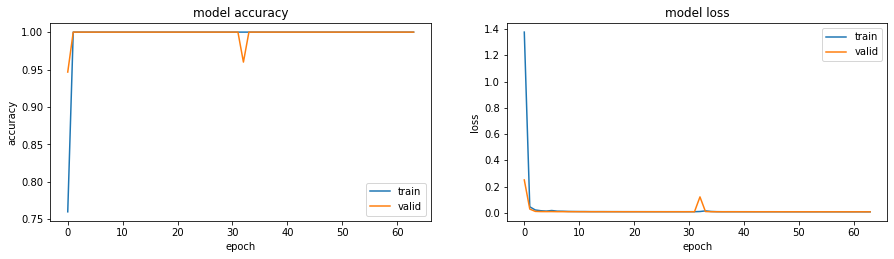

In [0]:
print(fit_history.history.keys())
plt.figure(1, figsize = (15,8))   
plt.subplot(221)  
plt.plot(fit_history.history['accuracy'])  
plt.plot(fit_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
plt.show()


In [0]:
# NOTE that flow_from_directory treats each sub-folder as a class which works fine for training data
# Actually class_mode=None is a kind of workaround for test data which too must be kept in a subfolder

# batch_size can be 1 or any factor of test dataset size to ensure that test dataset is samples just once, i.e., no data is left out
test_generator = validate_datagen.flow_from_directory(
    '/content/drive/My Drive/Face_D/Validation',
    target_size = (image_size, image_size),
    batch_size = 1,#BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)
# test generator for imposters
test_generator_random= validate_datagen.flow_from_directory(
    '/content/drive/My Drive/random',
    target_size = (image_size, image_size),
    batch_size = 1,#BATCH_SIZE_TESTING,
    class_mode = None,
    shuffle = False,
    seed = 123
)


FileNotFoundError: ignored

In [0]:
actual_labels = test_generator.classes
print("Actual Labels:\n",actual_labels)
# print(test_generator.filenames)

def load_model_and_weights():
    print("[INFO] Loading face model and its weights...")
    # Loading and using saved model steps
    # load json and create model
    js_file = open('/content/drive/My Drive/SAVED MODELS/Face Model/model22.json', 'r')
    loaded_model_json = js_file.read()
    js_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new loaded model
    loaded_model.load_weights('/content/drive/My Drive/SAVED MODELS/Face Model/best_face.h5')
    print("Loaded face model with its weights from drive")
    return loaded_model

# load the model and weights from directory
loaded_model= load_model_and_weights()

#pred = model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

# the loaded model predictions
pred = loaded_model.predict_generator(test_generator, steps = len(test_generator), verbose = 1)

random_pred=loaded_model.predict_generator(test_generator_random, steps = len(test_generator_random), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)
 
 # confusion matrix, all corrected classified classes are in the diagonal entries of the matrix
 # the colomuns are actual labels vs Rows as predicted Labels

cm = confusion_matrix(actual_labels,predicted_class_indices)
print(cm)


# print("Labels:\n")
# import tensorflow.keras
# np_utils.probas_to_classes
# class_names= keras.np_utils.probas_to_classes(pred)
# predicted_labels = y_proba.argmax(axis=-1)
# print(class_names)
for pre in pred:
    print(np.argmax(pre))
    

In [0]:
print(pred.shape)

# FAR calculator
tresh=[]
percent=[]
treshold=0
while  treshold <100:
    accepted_reg=0
    for registered_index in pred:
      counter_reg=0
      array_reg=np.array([0.0])
      max_confidence_reg = array_reg.astype(type('float32', (float,), {}))
      max_confIndex_reg=0
      for j in registered_index:
        if (j > max_confidence_reg):
          max_confidence_reg=j
          max_confIndex_reg=counter_reg
        counter_reg=counter_reg+1
      if(max_confidence_reg > treshold*0.01):
        accepted_reg+=1
    tresh.append(treshold)
    percent.append((80-accepted_reg)/80)
    treshold+=0.01


tresh_imp=[]
percent_imp=[]
treshold_imp=0
while  treshold_imp <100:
    accepted_imp=0
    for imp_index in random_pred:
      counter_imp=0
      array_imp=np.array([0.0])
      max_confidence_imp = array_imp.astype(type('float32', (float,), {}))
      max_confIndex_imp=0
      for j in imp_index:
        if (j > max_confidence_imp):
          max_confidence_imp=j
          max_confIndex_imp=counter_imp
        counter_imp+=1
      if(max_confidence_imp > treshold_imp*0.01):
        accepted_imp+=1
    tresh_imp.append(treshold_imp)
    percent_imp.append((accepted_imp)/80)
    treshold_imp+=0.01


equal_tresh=[]
equal_percent=[]
for i in range(0,len(tresh_imp)):
  if (percent_imp[i] == percent[i]):
     equal_tresh.append(tresh_imp[i])
     equal_percent.append(percent_imp[i])

print("Equal Treshold :",equal_tresh)
plt.plot(tresh,percent)
plt.plot(tresh_imp,percent_imp)
plt.plot(equal_tresh,equal_percent)
plt.title('Error Rate')  
plt.ylabel('percentage')  
plt.xlabel('treshold level')  
plt.legend(['FRR', 'FAR','EER']) 
plt.show()

In [0]:
# correct labeling function
def Correct_Labeling():
    import numpy as np
    count=0
    for indexx in pred:
      kk=0
      arrayedd=np.array([0.0])
      maxmm = arrayedd.astype(type('float32', (float,), {}))
      maxm_indexx=0
      for j in indexx:
        if (j > maxmm):
          maxmm=j
          maxm_indexx=kk
        kk=kk+1
      print("\n",maxm_indexx,maxmm)
      if maxmm < 0.80:
        count+=1
      print(count)


Correct_Labeling()

    

*`**`Iris Biometric System Starts from here`**`*

In [0]:
from google.colab import drive
drive.mount('/content/drive')